In [6]:
import warnings
warnings.filterwarnings("ignore", "Your application has authenticated using end user credentials")
from pyrds.data import gbq_query
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pyrds
from pyrds import marketmaker as mm
import pandas as pd
import numpy as np
import datetime
from collections import OrderedDict

from google.cloud import storage
from collections import defaultdict
import re
from decimal import Decimal
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import pygsheets
# from helpers import googlePanda

BQ_PROJECT = "dsr-core-proj-rcjtxz9f"

Helper functions to get order data

In [3]:
ORDER_CONFIGS = {
        "CS": {
            "bucket": "ripple-534sg4qax-crypto-systems",
            "filematch": r"CS_xrapid_([^_]+)_[0-9]{8}_ORDER\.csv$",
            "event_field": "event",
            "pair_field": "pair",
            "qty_field": "orderqty",
            "drop_cols": ["datetime","orderid","description"],
            },
        "GSR": {
            "bucket": "ripple-3493w092-gsr",
            "filematch": r"GSR_xrapid_([^_]+)_ORDER_[0-9]{8}\.csv$",
            "event_field": "data_type",
            "pair_field": "currency_pair",
            "qty_field": "size",
            "drop_cols": ["timestamp_est","exchange_order_id","tier_description"],   
            },
    }

CANCEL_CONFIGS = {
        "CS": {
            "bucket": "ripple-534sg4qax-crypto-systems",
            "filematch": r"CS_xrapid_([^_]+)_[0-9]{8}_CANCEL\.csv$",
            "event_field": "event",
            "pair_field": "pair",
            "qty_field": "canceledqty",
            "drop_cols": ["datetime","orderid","orderqty"],
            },
        "GSR": {
            "bucket": "ripple-3493w092-gsr",
            "filematch": r"GSR_xrapid_([^_]+)_CANCEL_[0-9]{8}\.csv$",
            "event_field": "data_type",
            "pair_field": "currency_pair",
            "qty_field": "cancel_qty",
            "drop_cols": ["timestamp_est","exchange_order_id","order_qty"],   
            },
    }

def match_files(date_map, config):
    res = []
    for date, date_files in date_map.items():
        for mm, files in date_files.items():
            conf = config[mm]
            for file in files:
                infile = f"gs://{config[mm]['bucket']}/{file}"
                df = pyrds.data.load_gcs_df(infile, thousands=",")
                df['human_timestamp'] = pd.to_datetime(df["timestamp"], unit="s")
                df['market_maker'] = mm
                df.rename(
                    columns={
                        conf['event_field']: 'event',
                        conf['pair_field']: 'pair',
                        conf['qty_field']: 'qty',
                    }, inplace=True)
                df.drop(conf['drop_cols'], axis=1, inplace=True)
                res.append(df)
    return pd.concat(res, sort=False)


def flatten_mm_df(df_mm):
    flattened_rows = []
    for idx, row in df_mm.iterrows():
        bids = row["snapshot"]["bids"]
        direction = "bids" if len(bids) > 0 else "asks"
        for bid in row["snapshot"][direction]: 
            _row = [row["human_timestamp_snapshot"], row["symbol"], row["human_timestamp"]]
            _row.extend([bid["price"], bid["size"]])
            flattened_rows.append(_row)
    flattened_cs = pd.DataFrame(flattened_rows, columns=["human_timestamp_snapshot","symbol","human_timestamp","price","size"])
    return flattened_cs


def get_order_data(date_str, exchanges, freq="5S"):
    
    date_obj = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    sdate = date_obj.strftime('%Y%m%d') # buffer for executions near the beginning of the day
    #edate = (end_date+pd.Timedelta(days=1)).strftime('%Y%m%d') # end date not inclusive in function
    edate = (date_obj + pd.Timedelta(days=1)).strftime('%Y%m%d')
    
    order_files = mm.determine_files(sdate, edate, config=ORDER_CONFIGS)
    cancel_files = mm.determine_files(sdate, edate, config=CANCEL_CONFIGS)
    orders_df = match_files(order_files, ORDER_CONFIGS)
    cancels_df = match_files(cancel_files, CANCEL_CONFIGS)
    
    book_df = pd.concat([orders_df, cancels_df], sort=False)
    book_df = book_df[book_df["exchange"].str.upper().isin([i.upper() for i in exchanges])]
    book_df = book_df[book_df["human_timestamp"] >= date_str]
    book_df['update_type'] = book_df['event'].apply(lambda x: 'ADD' if x=='ORDER' else 'SUB')
    book_df['is_buy'] = book_df['side'].apply(lambda x: 1 if x=='BUY' else 0)
    book_df['entry_px'] = book_df['price'].apply(lambda x: Decimal(x))
    book_df['entry_sx'] = book_df['qty'].apply(lambda x: Decimal(x))
    book_df['symbol'] = book_df['exchange'] + ' ' + book_df['pair']
    
    # get XRP daily close price in USD
    sql = f'''select data_date, symbol, close_usd from markets.cmc_ohlcv_daily
            where data_date="{date_str}" and symbol="XRP"'''
    _df = gbq_query(sql, project=BQ_PROJECT)
    xrp_rate = _df.iloc[0]["close_usd"]    

    mms = ["CS", "GSR"]
    results = []
    for _mm in mms:
        _df = book_df[book_df["market_maker"]==_mm]
        _grp = _df.groupby(['symbol','market_maker','is_buy'])
        _res = []
        for name, g in _grp:
            _ob_df = pyrds.orderbook.snapshots(freq, g, time='human_timestamp')
            _ob_df = _ob_df.resample(freq, on='human_timestamp_snapshot').first().ffill()
            _ob_df = _ob_df.drop('human_timestamp_snapshot', axis=1).reset_index()
            _res.append(_ob_df)
    
        _uptime_df = pd.concat(_res)
        _uptime_df = _uptime_df.resample(freq, on="human_timestamp").first().dropna()
        _uptime_df = flatten_mm_df(_uptime_df)
        
        # append XRP rate
        _uptime_df["qty_usd"] = xrp_rate * _uptime_df["size"].astype('float')
        _uptime_df.set_index("human_timestamp_snapshot", inplace=True)
        results.append(_uptime_df)
    

#     orders_df["xrp_rate"] = xrp_rate
#     orders_df["qty_usd"] = xrp_rate * orders_df["qty"]
#     orders_df = orders_df[orders_df["exchange"].str.upper().isin([i.upper() for i in exchanges])]
#     orders_df = orders_df[orders_df["human_timestamp"] >= date_str]
    return results

    
cs, gsr = get_order_data(date_str="2020-08-04", exchanges=["Bitso", "BITSO"], freq="5S")
#aa_cs, aa_gsr = get_order_data(date_str="2020-08-04", exchanges=["Bitso", "BITSO"])
cs

,symbol,human_timestamp,price,size,qty_usd
human_timestamp_snapshot,,,,,
2020-08-04 00:00:25,BITSO XRPMXN,2020-08-04 00:00:21.546000004,7,79600,23919.228141
2020-08-04 00:00:35,BITSO XRPMXN,2020-08-04 00:00:33.694999933,7.03000000000000024868995751603506505489349365...,42600,12800.993955
2020-08-04 00:00:35,BITSO XRPMXN,2020-08-04 00:00:33.694999933,7.00999999999999978683717927196994423866271972...,79500,23889.178860
2020-08-04 00:00:35,BITSO XRPMXN,2020-08-04 00:00:33.694999933,7,160500,48229.096943
2020-08-04 00:01:00,BITSO XRPMXN,2020-08-04 00:00:57.546000004,7.03000000000000024868995751603506505489349365...,42600,12800.993955
...,...,...,...,...,...
2020-08-04 20:58:50,BITSO XRPMXN,2020-08-04 20:58:45.144999981,6.71999999999999975131004248396493494510650634...,11445.786633999996411148459,3439.376655
2020-08-04 20:58:50,BITSO XRPMXN,2020-08-04 20:58:45.144999981,6.70999999999999996447286321199499070644378662...,142.2620645600036368705332,42.748728
2020-08-04 20:58:50,BITSO XRPMXN,2020-08-04 20:58:45.144999981,6.70000000000000017763568394002504646778106689...,31342.7793560299996897811070,9418.280025


Compare CS & GSR on time percentage of overlapping price

Overlapping pct on price threshold of: 0.0, when sampled at 5s
            same_price_cnt  total_cnt       pct
human_date                                     
2020-08-10            3779     139158  0.027156


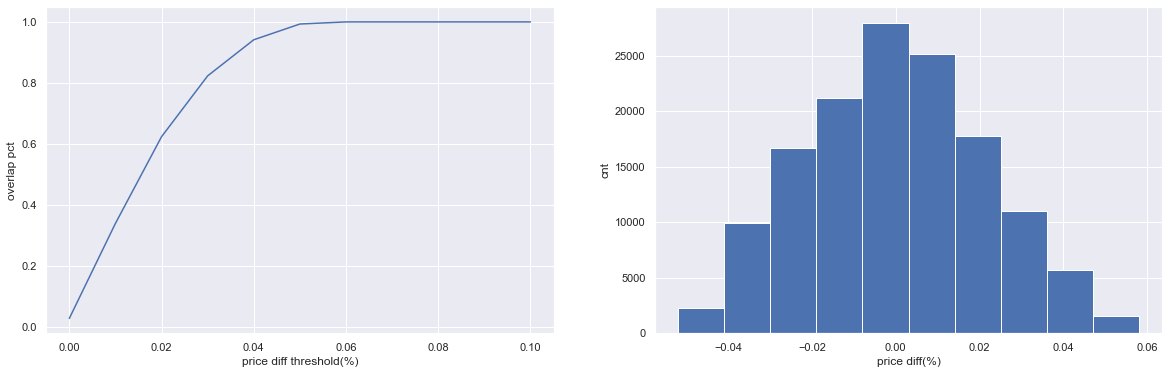

In [7]:
bitso_exchanges = ["Bitso", "BITSO"]
coinsph_exchanges = ["coinsph", "coins.ph"]
def compare_cs_gsr(date_str="2020-08-04", exchanges=bitso_exchanges, resample_rate="5s", 
                   quote_stack=10000, qty_threshold_low=0.05, qty_threshold_high=1, price_threshold=0.0):
#     orders_df = get_order_data(date_str, exchanges=exchanges)
#     # filter top tier quotes
#     orders_df = orders_df[(orders_df['qty_usd'] >= quote_stack * (1 - qty_threshold_low))&
#                           (orders_df['qty_usd'] <= quote_stack * (1 + qty_threshold_high))]
    
#     cs = orders_df[orders_df['market_maker']=='CS']
#     cs_resample = cs.resample(resample_rate, on="human_timestamp").first().dropna()

#     gsr = orders_df[orders_df['market_maker']=='GSR']
#     gsr_resample = gsr.resample(resample_rate, on="human_timestamp").first().dropna()
    
    cs, gsr = get_order_data(date_str, exchanges=exchanges)
    
    final = cs.merge(gsr, how="outer", suffixes=["_cs","_gsr"], left_index=True, right_index=True)
    final["price_diff"] = (final["price_cs"] - final["price_gsr"]) / final["price_gsr"]
    final["human_date"] = final["human_timestamp_cs"].dt.date
    # final["price_diff_abs"] = abs(final["price_diff"])
    
    groupers = OrderedDict([('same_price_cnt', lambda x: x[abs(x) <= price_threshold].count()),
                            ('total_cnt', lambda x: x.count())])
    overlap = final.groupby("human_date")["price_diff"].agg(groupers)
    overlap["pct"] = overlap["same_price_cnt"] / overlap["total_cnt"]
    print(f"Overlapping pct on price threshold of: {price_threshold}, when sampled at {resample_rate}")
    print(overlap)
    
    # plot overlap pct going with price threshold
    thresholds = list(np.linspace(0, 0.1, 11))
    _values = []
    for t in thresholds:
        groupers = OrderedDict([('same_price_cnt', lambda x: x[abs(x) <= t].count()),
                            ('total_cnt', lambda x: x.count())
                           ])
        _overlap = final.groupby("human_date")["price_diff"].agg(groupers)
        _overlap["pct"] = _overlap["same_price_cnt"] / _overlap["total_cnt"]
        _values.append(list(_overlap.values[0]) + [t])
    ts_df = pd.DataFrame(_values, columns=["same_price_cnt", "total_cnt", "pct", "threshold"])
    
    sns.set()
    figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(ts_df["threshold"], ts_df["pct"])
    plt.xlabel("price diff threshold(%)")
    plt.ylabel("overlap pct")
    plt.subplot(1, 2, 2)
    plt.hist(final["price_diff"].dropna())
    plt.xlabel("price diff(%)")
    plt.ylabel("cnt")
    
compare_cs_gsr(date_str="2020-08-10", exchanges=bitso_exchanges)

Overlapping pct on price threshold of: 0.0, when sampled at 10s
            same_price_cnt  total_cnt       pct
human_date                                     
2020-05-01            4304     311899  0.013799


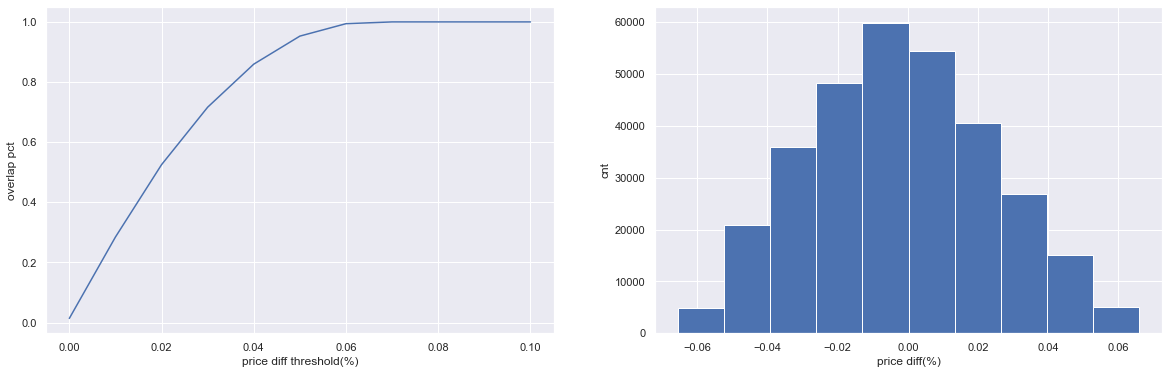

In [465]:
compare_cs_gsr(date_str="2020-05-01", exchanges=coinsph_exchanges, resample_rate="10s")

When setting price threshold at 0 (exact match) and sample rate at 10s, Bitso on 2020-08-04 has an overlapping price ratio of 28.7%. When increasing threshold to 0.02(0.029%), the overlapping ratio increases to 82.7%

Overlapping pct on price threshold of: 0.0, when sampled at 10s
            same_price_cnt  total_cnt      pct
human_date                                    
2020-07-25            3261     715130  0.00456


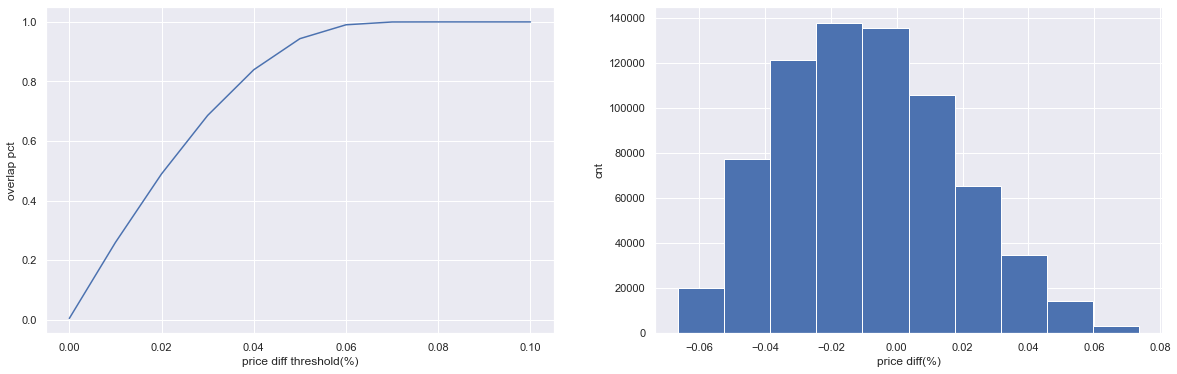

In [479]:
compare_cs_gsr(date_str="2020-07-25", exchanges=["BTCMarkets"], resample_rate="10s", 
               qty_threshold_low=0.1, qty_threshold_high=1)

Overlapping pct on price threshold of: 0.0, when sampled at 10s
            same_price_cnt  total_cnt       pct
human_date                                     
2020-07-25            1504      52306  0.028754


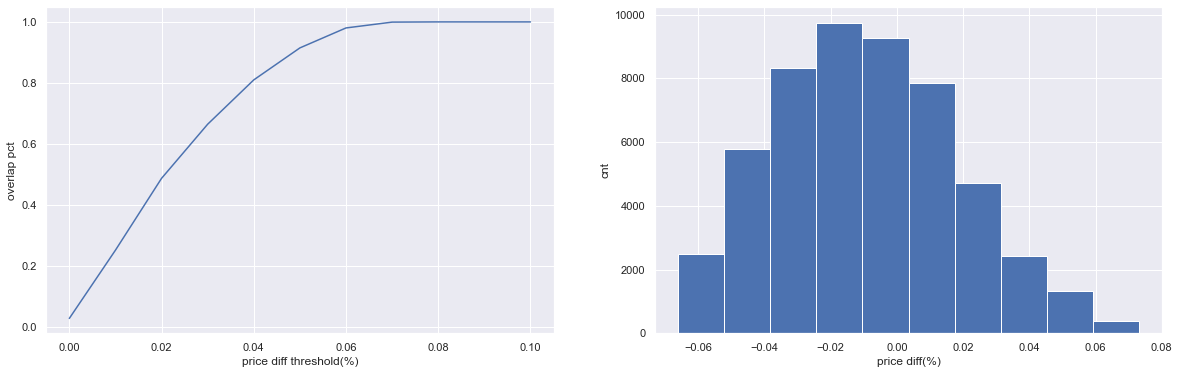

In [480]:
compare_cs_gsr(date_str="2020-07-25", exchanges=bitso_exchanges, resample_rate="10s")